In [1]:
import os, cv2
import numpy as np
import pandas as pd
import random, tqdm
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

import warnings
warnings.filterwarnings("ignore")

import torch
import torch.nn as nn
from torch.utils.data import DataLoader
import albumentations as album
import segmentation_models_pytorch as smp
from torch.utils.data import DataLoader
from torch.utils.data import Dataset as BaseDataset
import segmentation_models_pytorch.utils.metrics

In [2]:
DATA_DIR = '../roads_dataset/tiff/'

x_train_dir = os.path.join(DATA_DIR, 'train')
y_train_dir = os.path.join(DATA_DIR, 'train_labels')

x_valid_dir = os.path.join(DATA_DIR, 'val')
y_valid_dir = os.path.join(DATA_DIR, 'val_labels')

x_test_dir = os.path.join(DATA_DIR, 'test')
y_test_dir = os.path.join(DATA_DIR, 'test_labels')
print(x_train_dir)
def one_hot_encode(label, label_values):
    semantic_map = []
    for colour in label_values:
        equality = np.equal(label, colour)#Сарвниваем значения с значением пискеля маски
        class_map = np.all(equality, axis = -1)
        semantic_map.append(class_map)
    semantic_map = np.stack(semantic_map, axis=-1)
    return semantic_map
def rgb_to_onehot(label, label_values):
    
    sh = (len(label_values),label.shape[0], label.shape[1])
    new_label = np.zeros(sh, dtype='float')
    new_label[0] = np.where(label==0,1,0)
    new_label[1] = np.where(label==255,1,0)
#     for i in range(len(label)):
#         for j in range(len(label[0])):
#             if np.all(label[i][j] == label_values[0]):
#                 new_label[i][j] = [1.,0.]
#             else:
#                  new_label[i][j] = [0.,1.]
        
    return new_label
def reverse_one_hot(image):
    x = np.argmax(image, axis = -1)
    return x


../roads_dataset/tiff/train


In [3]:
class Dataset(BaseDataset):

    def __init__(
            self, 
            images_dir, 
            masks_dir, 
            class_rgb_values=None, 
            augmentation=None, 
            preprocessing=None,
    ):
        self.image_paths = []
        self.mask_paths = []
        for image_id in os.listdir(images_dir):
            self.image_paths.append (os.path.join(images_dir, image_id)) 
            self.mask_paths.append(os.path.join(masks_dir, image_id[:-1]) )
        
        self.class_rgb_values = class_rgb_values
        self.augmentation = augmentation
        self.preprocessing = preprocessing
    
    def __getitem__(self, i):
        
        # read images and masks
        image = cv2.imread(self.image_paths[i], cv2.COLOR_BGR2RGB)
        mask = cv2.imread(self.mask_paths[i], cv2.COLOR_BGR2GRAY)
#         plt.imshow(mask)
#         plt.show()
#         print(mask.shape)
#         print(mask)
#         print( self.class_rgb_values)
#         # one-hot-encode the mask
#         mask = one_hot_encode(mask, self.class_rgb_values).astype('float')
#        mask = rgb_to_onehot(mask, self.class_rgb_values)
        mask = [(mask == v) for v in [0,255]]
        mask = np.stack(mask, axis=-1).astype('float')
#         print(mask_1.shape)
#         print(mask_1)
#         print('my test')
#         print(rgb_to_onehot(mask,self.class_rgb_values).shape)
#         print(rgb_to_onehot(mask,self.class_rgb_values))
#         print(np.all(mask_1 == rgb_to_onehot(mask,self.class_rgb_values)))




        # apply augmentations
        if self.augmentation:
            sample = self.augmentation(image=image, mask=mask)
            image, mask = sample['image'], sample['mask']
        
        # apply preprocessing
        if self.preprocessing:
            sample = self.preprocessing(image=image, mask=mask)
            image, mask = sample['image'], sample['mask']
            
        return image, mask
        
    def __len__(self):
        # return length of 
        return len(self.image_paths)

In [4]:
def visualize(**images):
    """
    Plot images in one row
    """
    n_images = len(images)
    plt.figure(figsize=(20,8))
    for idx, (name, image) in enumerate(images.items()):
        plt.subplot(1, n_images, idx + 1)
        plt.xticks([]); 
        plt.yticks([])
        # get title from the parameter names
        plt.title(name.replace('_',' ').title(), fontsize=20)
        plt.imshow(image)
    plt.show()

In [5]:
class_dict = pd.read_csv("../roads_dataset/label_class_dict.csv")
# Get class names
class_names = class_dict['name'].tolist()
# Get class RGB values
class_rgb_values = class_dict[['r','g','b']].values.tolist()
print(class_names)
print(class_rgb_values)

['background', 'road']
[[0, 0, 0], [255, 255, 255]]


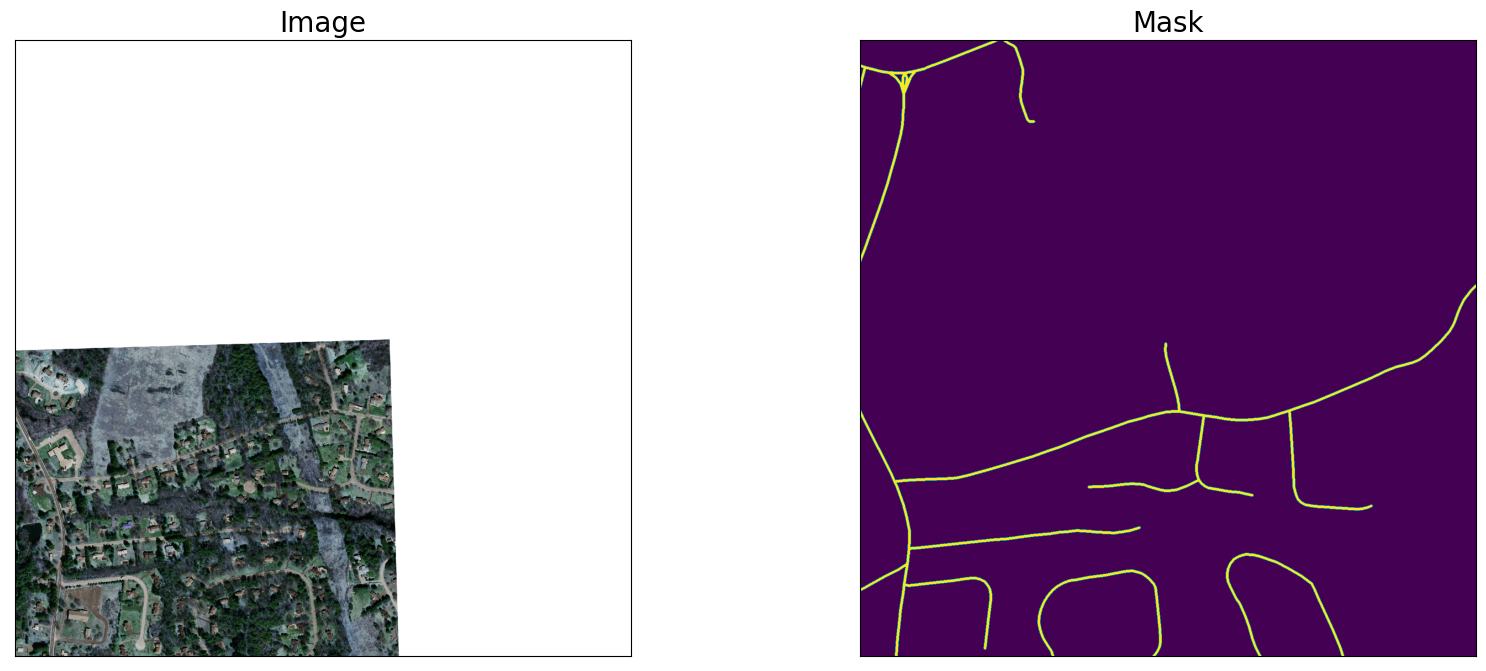

[[[1. 0.]
  [1. 0.]
  [1. 0.]
  ...
  [1. 0.]
  [1. 0.]
  [1. 0.]]

 [[1. 0.]
  [1. 0.]
  [1. 0.]
  ...
  [1. 0.]
  [1. 0.]
  [1. 0.]]

 [[1. 0.]
  [1. 0.]
  [1. 0.]
  ...
  [1. 0.]
  [1. 0.]
  [1. 0.]]

 ...

 [[1. 0.]
  [1. 0.]
  [1. 0.]
  ...
  [1. 0.]
  [1. 0.]
  [1. 0.]]

 [[1. 0.]
  [1. 0.]
  [1. 0.]
  ...
  [1. 0.]
  [1. 0.]
  [1. 0.]]

 [[1. 0.]
  [1. 0.]
  [1. 0.]
  ...
  [1. 0.]
  [1. 0.]
  [1. 0.]]]
(1500, 1500, 2)
[0 1]
[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]
(1500, 1500)


In [6]:
dataset = Dataset(x_train_dir, y_train_dir, class_rgb_values=class_rgb_values)
random_idx = random.randint(0, len(dataset)-1)
image, mask = dataset[random_idx] # get some sample

visualize(
    image=image, 
    mask= reverse_one_hot(mask),
)
print(mask)
print(mask.shape)
# print(one_hot_encode(mask, class_rgb_values))
# print(rgb_to_onehot(mask,class_rgb_values))

print(np.unique(reverse_one_hot(mask)))
# # for i in reverse_one_hot(mask)[0]:
print (reverse_one_hot(mask))
print(reverse_one_hot(mask).shape)




In [7]:
def get_training_augmentation():
    train_transform = [    
        album.RandomCrop(height=256, width=256, always_apply=True),
        album.OneOf(
            [
                album.HorizontalFlip(p=1),
                album.VerticalFlip(p=1),
                album.RandomRotate90(p=1),
            ],
            p=0.75,
        ),
    ]
    return album.Compose(train_transform)

def get_validation_augmentation():
    """Add paddings to make image shape divisible by 32"""
    test_transform = [
        album.Resize(224,224),
  #      albu.PadIfNeeded(256, 256)
    ]
    return album.Compose(test_transform)


def to_tensor(x, **kwargs):
    return x.transpose(2, 0, 1).astype('float32')

def get_preprocessing(preprocessing_fn):
    """Construct preprocessing transform
    
    Args:
        preprocessing_fn (callbale): data normalization function 
            (can be specific for each pretrained neural network)
    Return:
        transform: albumentations.Compose
    
    """
    
    _transform = [
        album.Lambda(image=preprocessing_fn),
        album.Lambda(image=to_tensor, mask=to_tensor),
    ]
    return album.Compose(_transform)

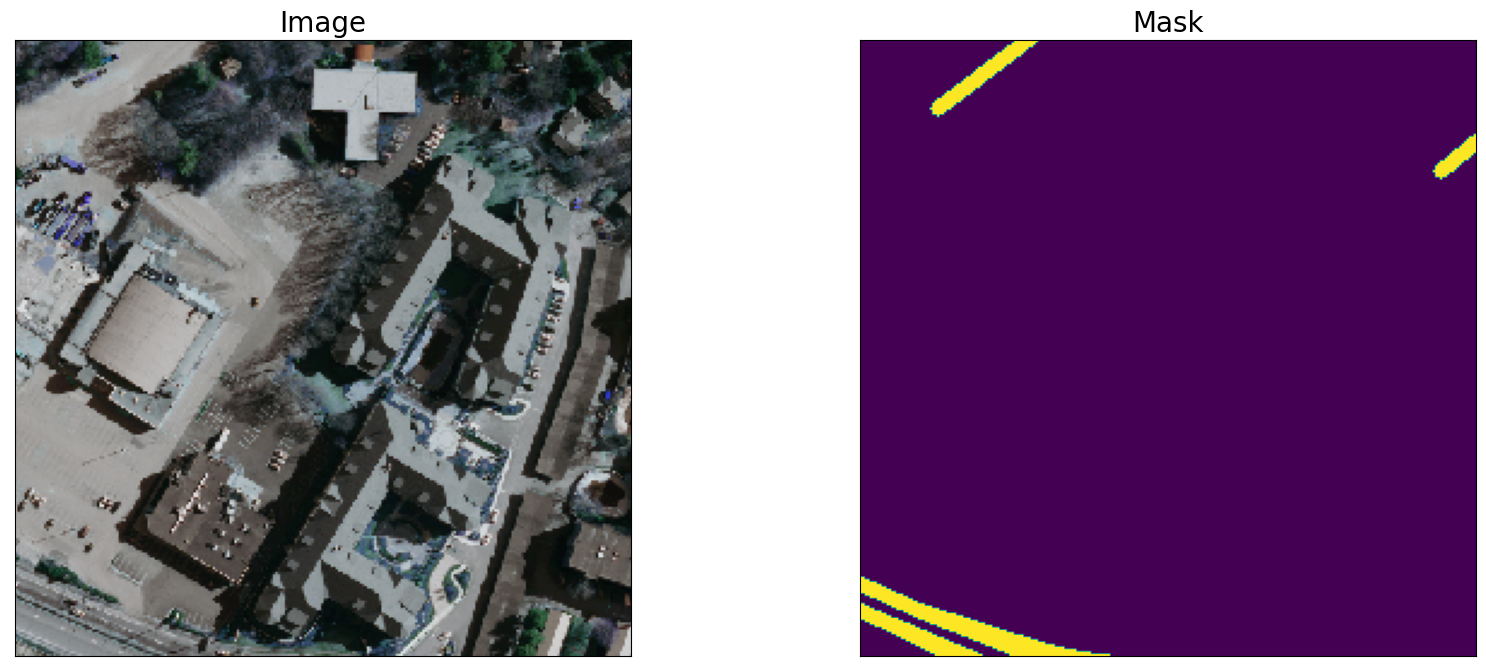

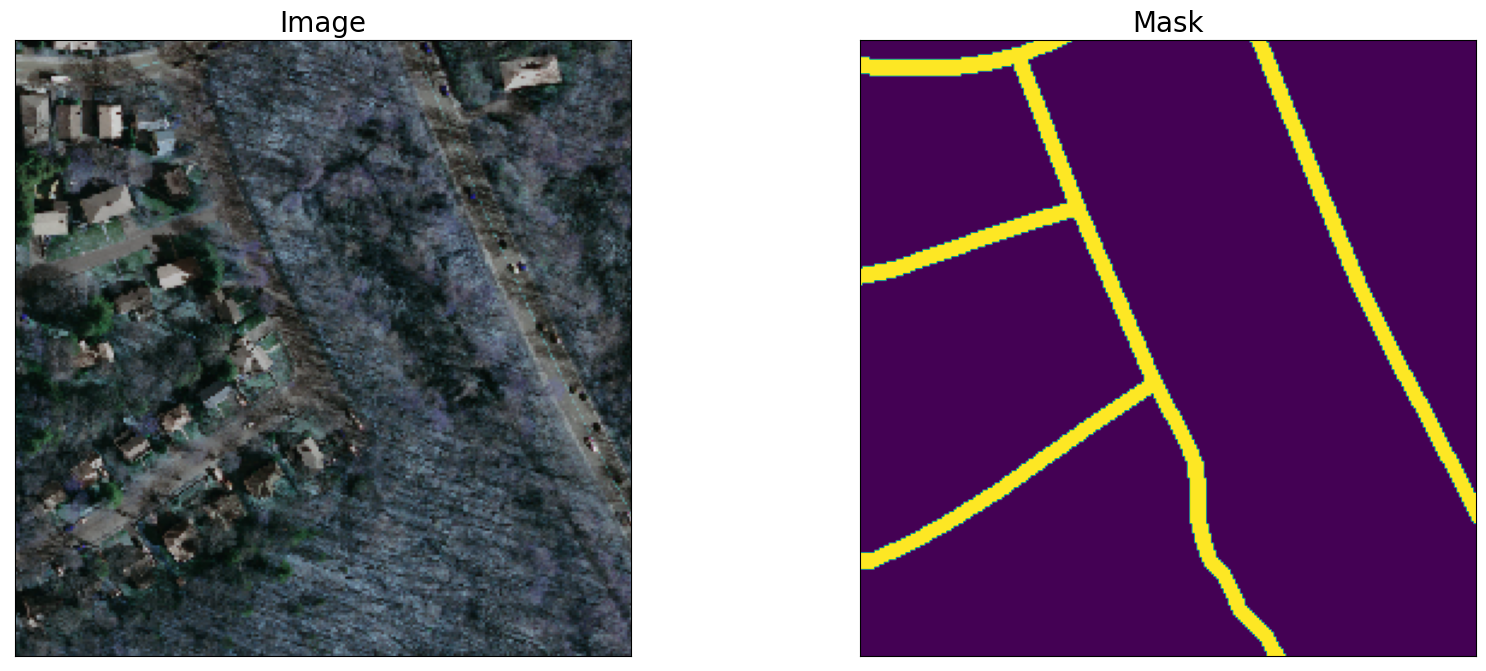

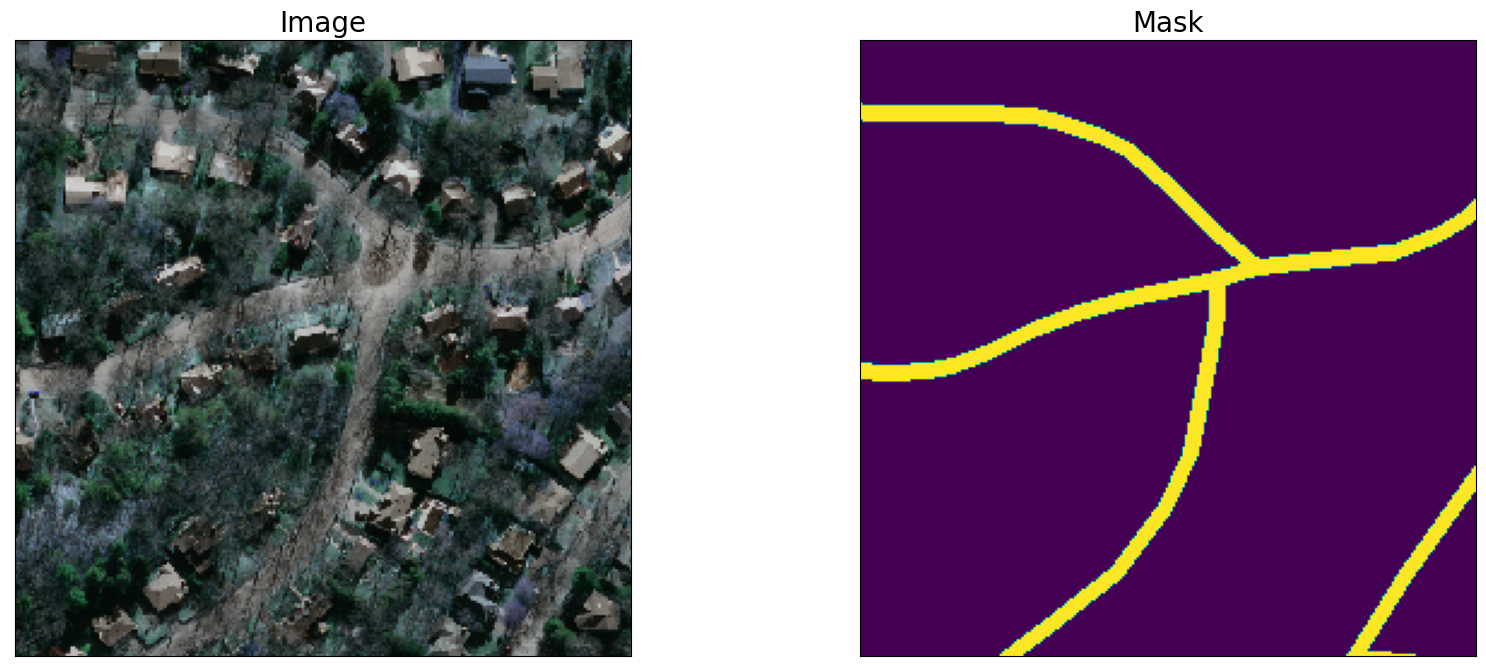

In [8]:
augmented_dataset = Dataset(
    x_train_dir, y_train_dir,
    augmentation=get_training_augmentation(), 
     class_rgb_values=class_rgb_values,
)

# same image with different random transforms
for i in range(3):
    image, mask = augmented_dataset[1]
    visualize(image=image, mask=reverse_one_hot(mask))

In [9]:
ENCODER = 'resnet50'
ENCODER_WEIGHTS = 'imagenet'
CLASSES = class_names
ACTIVATION = 'sigmoid' # could be None for logits or 'softmax2d' for multiclass segmentation
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# create segmentation model with pretrained encoder
model = smp.Unet(
    encoder_name=ENCODER, 
    encoder_weights=ENCODER_WEIGHTS, 
    classes=len(CLASSES), 
    activation=ACTIVATION,
)

preprocessing_fn = smp.encoders.get_preprocessing_fn(ENCODER, ENCODER_WEIGHTS)
train_dataset = Dataset(
    x_train_dir, y_train_dir, 
    augmentation=get_training_augmentation(),
    preprocessing=get_preprocessing(preprocessing_fn),
    class_rgb_values=class_rgb_values,

)

valid_dataset = Dataset(
    x_valid_dir, y_valid_dir, 
    augmentation=get_validation_augmentation(), 
    preprocessing=get_preprocessing(preprocessing_fn),
    class_rgb_values=class_rgb_values,
)

# Get train and val data loaders
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True, num_workers=4)
valid_loader = DataLoader(valid_dataset, batch_size=1, shuffle=False, num_workers=4)

In [10]:
# Dice/F1 score - https://en.wikipedia.org/wiki/S%C3%B8rensen%E2%80%93Dice_coefficient
# IoU/Jaccard score - https://en.wikipedia.org/wiki/Jaccard_index

loss = smp.utils.losses.DiceLoss()
metrics = [
    smp.utils.metrics.IoU(threshold=0.5),
]

optimizer = torch.optim.Adam([ 
    dict(params=model.parameters(), lr=0.0001),
])

In [11]:
train_epoch = smp.utils.train.TrainEpoch(
    model, 
    loss=loss, 
    metrics=metrics, 
    optimizer=optimizer,
    device=DEVICE,
    verbose=True,
)

valid_epoch = smp.utils.train.ValidEpoch(
    model, 
    loss=loss, 
    metrics=metrics, 
    device=DEVICE,
    verbose=True,
)

In [ ]:
max_score = 0

for i in range(0, 10):
    
    print('\nEpoch: {}'.format(i))
    train_logs = train_epoch.run(train_loader)
    valid_logs = valid_epoch.run(valid_loader)
    
    # do something (save model, change lr, etc.)
    if max_score < valid_logs['iou_score']:
        max_score = valid_logs['iou_score']
        torch.save(model, './best_model.pth')
        print('Model saved!')
        
    if i == 25:
        optimizer.param_groups[0]['lr'] = 1e-5
        print('Decrease decoder learning rate to 1e-5!')


Epoch: 0
valid: 100%|██████████| 14/14 [00:00<00:00, 31.11it/s, dice_loss - 0.3229, iou_score - 0.8162]
Model saved!

Epoch: 1
valid: 100%|██████████| 14/14 [00:00<00:00, 31.91it/s, dice_loss - 0.2512, iou_score - 0.8517]
Model saved!

Epoch: 2
valid: 100%|██████████| 14/14 [00:00<00:00, 35.03it/s, dice_loss - 0.188, iou_score - 0.8614]
Model saved!

Epoch: 3
valid: 100%|██████████| 14/14 [00:00<00:00, 32.82it/s, dice_loss - 0.1642, iou_score - 0.8646]
Model saved!

Epoch: 4
valid: 100%|██████████| 14/14 [00:00<00:00, 35.66it/s, dice_loss - 0.1277, iou_score - 0.8722]
Model saved!

Epoch: 5
valid: 100%|██████████| 14/14 [00:00<00:00, 32.44it/s, dice_loss - 0.1148, iou_score - 0.8702]

Epoch: 6
train:  66%|██████▌   | 46/70 [00:07<00:03,  7.37it/s, dice_loss - 0.08034, iou_score - 0.9336]